# Binomial Smoothing of a 1D data set

**Abstract**<br>
*This notebook implements an N pass binomial smoothing algorithm from Marchand and Marmet, and illustrates it's usage and shows how binomial smoothing supresses high frequency noise. One of the other examples shown is how to use binomial smoothing to create a more physically reasonable step function and pulse.*
### References: 
**1.** *Binomial smoothing filter: A way to avoid some pitfalls of least‐squares polynomial smoothing* <br>
Review of Scientific Instruments 54, 1034 (1983); https://doi.org/10.1063/1.1137498 <br> 
or https://aip.scitation.org/doi/abs/10.1063/1.1137498

**2.** A good discussion of smoothing in general is [A Pragmatic Introduction to Signal Processing](https://terpconnect.umd.edu/~toh/spectrum/Smoothing.html), <br>
created and maintained by Prof. Tom O'Haver , Department of Chemistry and Biochemistry, <br>
The University of Maryland at College Park. https://terpconnect.umd.edu/~toh/spectrum/Smoothing.html

**3.** Another excellent reference is a blog post by Bart Wronski<br>
[Practical Gaussian filtering: Binomial filter and small sigma Gaussians.](https://bartwronski.com/2021/10/31/practical-gaussian-filter-binomial-filter-and-small-sigma-gaussians/)

## Binomial Smoothing: background
I'll talk about this in terms of smoothing data from a time series, though the method really applies to any 1D array (vector). 
Binomial smoothing takes the initial data set and uses a $2N_p + 1$ point smoothing vector computed by the $2N_p +1$ row of Pascal's triangle to average over the initial data set. In general, this vector's elements are computed by <br>
(taken *directly from P. Marchand and L. Marmet's paper* referenced above)

$$ b_k = \frac{1}{4^{N_p}} \binom{2N_p}{N_p + k}, \;\; (k = 0,1,...,N_p) $$
and $b_{-k} = b_k$

For instance: <br>
    if $N_p = 1$, the three point smoothing vector is $b_{-1,0,1} = [1, 2, 1]/4$<br>
    if $N_p = 2$, the three point smoothing vector is $b_{-2,-1,0,1,2} = [1, 4, 6, 4, 1]/16$<br>
These coefficients come from the odd-numbered rows of Pascal's Triangle (staring with row 3).
However, if you consider the array 

$$ \mathrm{data} = [1, 3, 6, 2, 0, 7], $$

you can see that if $N_p = 1$, that one can average only the points with indicees 2 through 5, as the left and right endpoints of the data set do not have values to the left and right respectively. There are several ways to deal with this (see Ref. 2), but the method Marchand and Marmet use preserved the values of the endpoints (a nice feature) by extending the first and last points in the sequence via <br>

 $$x_{1-i} = 2x_1 - x_i \;\;\mathrm{and} \;\;\;  x_{N+i} = 2x_N - x_{N-i}$$
 
and computes the $N$-point data set with smoothed values computed by $N_p$ repeated three point binomial filters.

Their algorithm implemented in the function *binomial_smooth* is as follows:

$$ \begin{align*}
    x_1     & = (y_1 + y_2)/2\\
    x_k     & = (y_k + y_{k+1})/2\\
    x_{k-1} & = (y_{N-1} + y_N)/2\\
    z_1     & = y_1\\
    z_k     & = (x_{k-1} + x_k)/2\\
    z_{N-1} & = (x_{N-2} + x_{N-1})/2\\
    z_N     & = y_N\\
    \end{align*}
$$

One execution ($N_p = 1$) of the above algorithm is equivalent to a single 3 point binomial smoothing pass; 2 executions are equal to a single application of a 5 point binomial smoothing pass (it is left as an exercise for the reader to verify that this works :-).

In [1]:
    """
        binomial(data::Vector, Nₚ::Int)

    Takes a 1d data array and smooths the data with a 2Nₚ+1 binomial filter.
    This is computed using the method outlined in: <br>

    *Binomial smoothing filter: A way to avoid some pitfalls of least‐squares
    polynomial smoothing* in Review of Scientific Instruments 54, 1034 (1983);
    https://doi.org/10.1063/1.1137498 <br>

    or see <br>
    https://aip.scitation.org/doi/abs/10.1063/1.1137498

    The method implements a 2Nₚ+1 binomial filter by Nₚ passes of the three point
    binomial filter; and this is computationally implemented by two passess of the
    {1,1}/2 smoothing implemented below.

    # Examples (you can easily manually verify data1's smoothing is correct.)
    ```julia-repl
    julia> data1 = [1.0, 2.0, 3.0, 4.0, 5.0]
    julia> data2 = [3.0, 6.0, 1.0, 4.0, 0.0]
    julia> binomial(data1, 1)

    5-element Vector{Float64}:
     1.0
     2.0
     3.0
     4.0
     5.0

    julia> binomial(data2, 20)

    5-element Vector{Float64}:
     3.0
     2.3162835515104234
     1.5937387603335083
     0.8162830746732652
     0.0
    ```
    """
    function binomial(data::Vector, Nₚ::Int)
        y = data
        for pass in 1:Nₚ
            x = zeros(length(data))

            for i in 1:length(y)
                if i==1
                    x[i] = (y[i] + y[i+1])/2.0
                elseif i>1 && i<length(y)
                    x[i] = (y[i] + y[i+1])/2.0
                end
            end

            y = zeros(length(data))

            for j in 1:length(x)
                if j==1
                    y[j] = data[j]
                elseif j>1 && j<length(x)
                    y[j] = (x[j-1] + x[j])/2.0
                else
                    y[j] = data[j]
                end
            end

        end

        return y
    end

binomial

## Examples using the binomial smoothing algorithm
### 1. Two simple data arrays
It is a simple matter to prove that the data1 array listed below transforms to itself under a 3 point binomial smoothing<br>
(assuming the endpoint preserving extensions $x_{1-i} = 2x_1 - x_i$ and $x_{N+i} = 2x_N - x_{N-i}$)

In [9]:
data1 = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
data1_smoothed = binomial(data1, 1) # easy to manually check this using [1, 2, 1]/4 weighting 
println("data1_smoothed (1 pass) = ", data1_smoothed )

data1_smoothed (1 pass) = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]


Similarly, one would expect a single pass of binomial smoothing on the triangle wave below<br>
would look triangular, but with a peak height of only 5.0:

In [11]:
data2 = [0.0, 2.0, 4.0, 6.0, 4.0, 2.0, 0.0]
data2_smoothed = binomial(data2, 1)
println("data2_smoothed (1 pass) ≈ ", round.(data2_smoothed, digits=3))

data2_smoothed (1 pass) ≈ [0.0, 2.0, 4.0, 5.0, 4.0, 2.0, 0.0]


### 2. Noisy data:
I'll create fake noisy data by adding Gaussian noise to a sine wave:

In [12]:
using Random
using Distributions
using Plots; gr()
using LaTeXStrings
using DSP
using Printf
using Interact

Random.seed!(123) # Setting the seed

MersenneTwister(123)

Now, I will make a set of times from 0.0 to 4.0 seconds sampled every 0.01 seconds. 
I'll then make some Gaussian noise<br>
with a variance $\sigma^2 = 4$, add that to a sinusoidal signal with period 2.0 seconds.
The plot will show<br> the raw data, and two different smoothing levels, 4 pass, and 100 pass binomial smoothing.

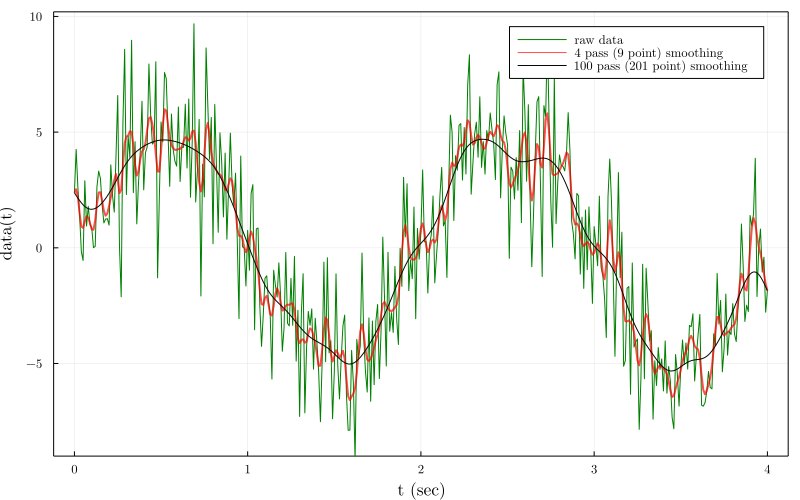

In [13]:
t = collect(range(0.0, stop=4.0, step=0.01))

# make some gaussian noise with variance σ^2:
μ=0.0
σ=2.0
d = Normal(μ, σ)      # Normal distribution with mean μ and variance σ^2
noise = rand(d, length(t))

# add noise to the signal (period = 2.0 seconds)
data =  5*sin.(2π*t/2.0) + noise
data_smoothed_4 = binomial(data, 4);
data_smoothed_100 = binomial(data, 100);


plot(t, data, ylabel="data(t)", xlabel="t (sec)", size=(800,500),
      label="raw data", framestyle = :box, color="green", fontfamily="Computer Modern")
plot!(t, data_smoothed_4, label="4 pass (9 point) smoothing", 
      linewidth=2, alpha=0.7, ylim=(-9,10.2), color="red")
plot!(t, data_smoothed_100, label="100 pass (201 point) smoothing", 
      linewidth=1, alpha=0.97, ylim=(-9,10.2), color="black")

### Look at the frequency content of the data
As the plot above shows, binomial smoothing does a great job of reducing high frequency noise,
we can see this if we look at the power spectra for the curves plotted above:

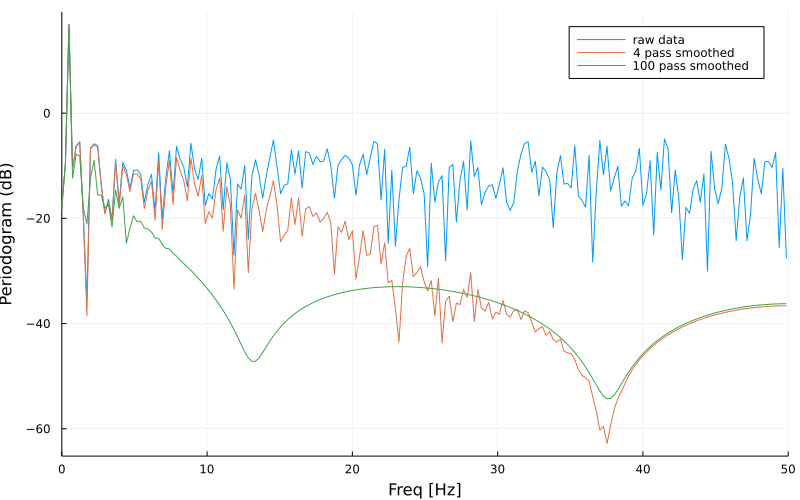

In [15]:
fft_raw = periodogram(data; fs=100)
fft_4 = periodogram(data_smoothed_4; fs=100)
fft_100 = periodogram(data_smoothed_100; fs=100)
p2 = plot(;xlabel="Freq [Hz]",ylabel="Periodogram (dB)", 
    xlims=(0,50), grid=true, size=(800,500))
plot!(p2, fft_raw.freq, DSP.pow2db.(fft_raw.power), label="raw data")
plot!(p2, fft_4.freq, DSP.pow2db.(fft_4.power), label="4 pass smoothed")
plot!(p2, fft_100.freq, DSP.pow2db.(fft_100.power), label="100 pass smoothed")

The plot below merges the above two plots and adds the ability to interactively change $\sigma$ and the number of smoothing passes. <br>
**NOTE: Bug!** <br>
*There seems to be an issue in (I'm guessing here) Interact.jl - you will likely find that the sliders move, but
the plots do not update. If that happens, it turns out you can reload this page in your browser, and re-execute the cell below. This should allow the interactivity to work properly.*

In [16]:
f_sample = 100    # Sampling frequency
t = collect(range(0.0, stop=4.0, step=1.0/f_sample))
mp = @manipulate for σ in slider(1.0:0.1:5.0; label="σ"), N_pass in slider(1:1:100; label="# Passes")
#@manipulate throttle=0.05 for σ=1.0:0.1:5.0, N_pass=1:1:100
    # make some gaussian noise with variance σ^2:
    Random.seed!(123) # Setting the seed means we get the same random distribution when each slider updates. 
    μ=0.0
    d = Normal(μ, σ)      # Normal distribution with mean μ and variance σ^2
    noise = rand(d, length(t))

    # add noise to the signal (period = 2.0 seconds)
    data =  @. 5*sin(2π*t/2.0) + noise
    data_smoothed =  binomial(data, N_pass)
    fft_raw = periodogram(data; fs=f_sample)
    fft_smooth = periodogram(data_smoothed; fs=f_sample)

    p1 = plot(t, [data, data_smoothed], ylabel=["data(t)" "smoothed data"], xlabel="t (sec)",
          label=["raw data" "smoothed"], framestyle = :box, color=["cadetblue" "red"],
          linewidth=[1 3], alpha=[1.0 0.6], fontfamily="Computer Modern"
        )
    #plot!(t, data_smoothed, label="smoothed data", color="red", linewidth=3, alpha=0.6)
    p2 = plot(fft_raw.freq, [DSP.pow2db.(fft_raw.power),  DSP.pow2db.(fft_smooth.power)], 
              label=["raw" "smoothed"], xlabel="Freq [Hz]",ylabel="Periodogram (dB)", xlims=(0,f_sample/2), grid=true)
    plot(p1, p2, size=(1000,500), margin=5.0mm)
    
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["σ"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 41, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
21, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/pauln/.julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/pauln/.julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/pauln/.julia/packages/InteractBase/o1I6G/src/../assets/all.js"), Asset("css", nothing, "/Users/pauln/.julia/packages/InteractBase/o1I6G/src/../assets/style.css"), Asset("css", nothing, "/Users/pauln/.julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000015322cde0, Task (runnable) @0x000000015322cde0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1.0\",\"1.1\",\"1.2\",\"1.3\",\"1.4\",\"1.5\",\"1.6\",\"1.7\",\"1.8\",\"1.9\",\"2.0\",\"2.1\",\"2.2\",\"2.3\",\"2.4\",\"2.5\",\"2.6\",\"2.7\",\"2.8\",\"2.9\",\"3.0\",\"3.1\",\"3.2\",\"3.3\",\"3.4\",\"3.5\",\"3.6\",\"3.7\",\"3.8\",\"3.9\",\"4.0\",\"4.1\",\"4.2\",\"4.3\",\"4.4

### 3. Smoothing a pulse and a step
Many times in physics, we want to know how a system responds to either a square pulse or a step function, or we want to explore the time evolution of a system which is initialized in a state of these shapes. For instance, a common problem is to explore the time evoltion of a one-dimensional rod where each half is at a different initial temperature. Although it is *mathematically* possible to create such an initial configuration, it is *physically* impossible to exactly achieve this. More reasonably, the initial state will be similar to the smoothed step function below. 

The examples below show how we can use the binomial smoothing function to create a more physically reasonable pulse or step:

In [17]:
Δt = 0.01
t = collect(range(0.0, stop=4.0, step=Δt))
step = [val>2.0 for val in t]
pulse = [val>1.5 && val<2.5 for val in t]
step_smooth = binomial(step,100);

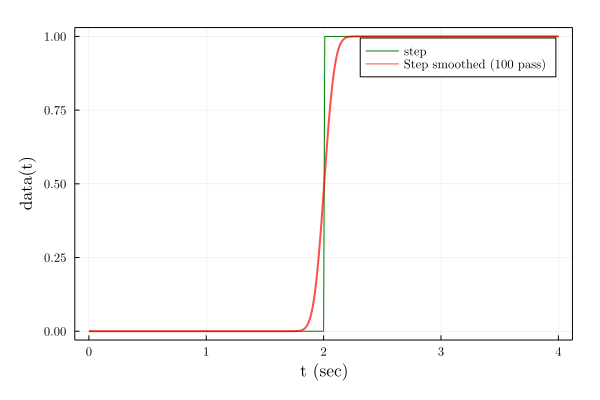

In [18]:
plot(t, step, ylabel="data(t)", xlabel="t (sec)", size=(600,400),
      label="step", framestyle = :box, color="green", 
      fontfamily="Computer Modern", fontsize=10, margin = 5mm)
plot!(t, step_smooth, label="Step smoothed (100 pass)", 
      linewidth=2, alpha=0.7, color="red")

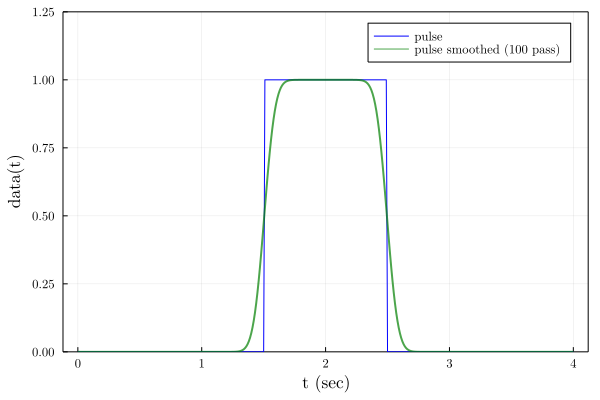

In [19]:
Δt = 0.01
fs = 1/Δt
t = collect(range(0.0, stop=4.0, step=Δt))
pulse = [val>1.5 && val<2.5 for val in t]
pulse_smooth = binomial(pulse,100);
plot(t, pulse, ylabel="data(t)", xlabel="t (sec)", size=(600,400),
      label="pulse", framestyle = :box, color="blue", 
      fontfamily="Computer Modern")
plot!(t, pulse_smooth, label="pulse smoothed (100 pass)", 
      linewidth=2, alpha=0.7, ylim=(0,1.25), color="green",
      left_margin = 2mm, bottom_margin=2mm)

As expected, the power spectrum of the smoothed signal contains far fewer high frequency components:

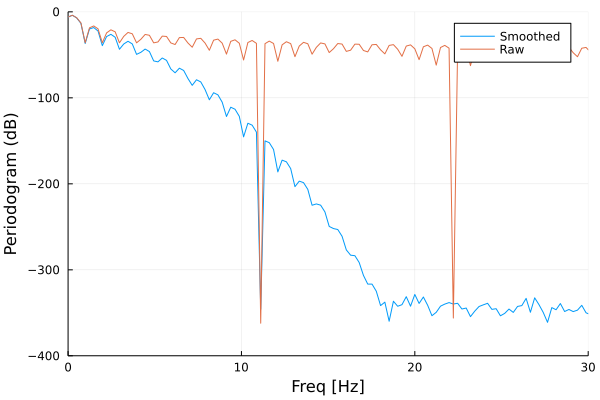

In [20]:
# Compute:
S_pulse = periodogram(pulse; fs=fs)
S_pulse_smooth = periodogram(pulse_smooth; fs=fs)


# Plot:
str = "Δt = " * string(Δt*1e3) * " ms"
plot(;xlabel="Freq [Hz]",ylabel="Periodogram (dB)", xlims=(0,30), ylims=(-400,0), grid=true)
plot!(S_pulse_smooth.freq, DSP.pow2db.(S_pulse_smooth.power), label="Smoothed")
plot!(S_pulse.freq, DSP.pow2db.(S_pulse.power), label="Raw")



### Comments, feedback, errors?
Please contact Paul Nakroshis (www.portlandphysics.me) pauln at maine dot edu with any comments or bugs.